In [ ]:
# Imports
import glob
import numpy as np
import imageio
import os.path as path
from scipy import misc

In [ ]:
!apt-get install p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [ ]:
from google.colab import drive
import os

#Step 1: Mount Google Drive
#drive.mount('/content/drive')

# Step 2: Define the path to the .7z file in Google Drive
seven_z_file_path = '/content/drive/MyDrive/planesnet.7z'

# Step 3: Create a directory to extract the contents
extracted_folder = '/content/planesnets'
os.makedirs(extracted_folder, exist_ok=True)

# Step 4: Extract the .7z file using the p7zip command
!7z x {seven_z_file_path} -o{extracted_folder}

# Step 5: List the extracted files to verify
extracted_files = os.listdir(extracted_folder)
print(extracted_files)



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,96 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 25627383 bytes (25 MiB)

Extracting archive: /content/drive/MyDrive/planesnet.7z
--
Path = /content/drive/MyDrive/planesnet.7z
Type = 7z
Physical Size = 25627383
Headers Size = 643091
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     12% 1       12% 716 - planesnet/0__20150827_012505_0b0f__-118.39926911_33.9407479463.png                                                                              12% 1157 - planesnet/0__20151015_213908_1 . 117.6017861

In [ ]:
IMAGE_PATH = '/content/planesnets/planesnet'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the images
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

<ipython-input-20-e3d572620368>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(path) for path in file_paths]


In [ ]:
print(images.shape)  # This should give something like (n_images, height, width, channels)


(32000, 20, 20, 3)


In [ ]:
# Scale
images = images / 255

In [ ]:
# Read the labels from the filenames
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [ ]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.8

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def visualize_data(positive_images, negative_images):

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

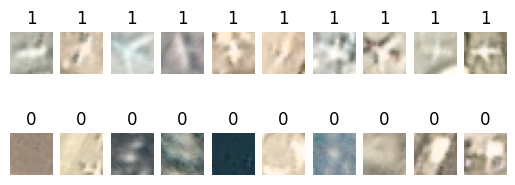

In [ ]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 10

positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

visualize_data(positive_examples, negative_examples)

In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
# Imports
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

In [ ]:
# Hyperparamater
N_LAYERS = 4

In [ ]:
def cnn(size, n_layers):

    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    model = Sequential()

    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
# Instantiate the model
image_size=images[0].shape
print(image_size)
model = cnn(image_size,N_LAYERS)

(20, 20, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 20)        560       
                                                                 
 activation (Activation)     (None, 18, 18, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 44)        7964      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 44)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 68)        26996     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 68)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 

In [ ]:
EPOCHS = 100
BATCH_SIZE = 200

In [ ]:
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=1, mode='auto')

In [ ]:
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [ ]:
callbacks = [early_stopping, tensorboard]

In [ ]:
# Train the model
history=model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)

Epoch 1/100
128/128 [==============================] - 6s 38ms/step - loss: 0.4137 - accuracy: 0.7856
Epoch 2/100
128/128 [==============================] - 5s 38ms/step - loss: 0.2757 - accuracy: 0.9026
Epoch 3/100
128/128 [==============================] - 5s 37ms/step - loss: 0.2492 - accuracy: 0.9231
Epoch 4/100
128/128 [==============================] - 5s 37ms/step - loss: 0.2212 - accuracy: 0.9415
Epoch 5/100
128/128 [==============================] - 5s 35ms/step - loss: 0.1931 - accuracy: 0.9564
Epoch 6/100
128/128 [==============================] - 4s 34ms/step - loss: 0.1723 - accuracy: 0.9630
Epoch 7/100
128/128 [==============================] - 4s 32ms/step - loss: 0.1648 - accuracy: 0.9623
Epoch 8/100
128/128 [==============================] - 4s 33ms/step - loss: 0.1477 - accuracy: 0.9703
Epoch 9/100
128/128 [==============================] - 4s 32ms/step - loss: 0.1325 - accuracy: 0.9743
Epoch 10/100
128/128 [==============================] - 4s 32ms/step - loss: 0.122

In [ ]:
# Make a prediction on the test set

# No need for tf.get_default_graph() or graph management in TensorFlow 2.x
# Perform predictions directly
test_predictions = model.predict(x_test)

# Round the predictions if needed (typically for classification problems)
test_predictions = np.round(test_predictions)

# Print the size of the predictions array
print(test_predictions.size)



200/200 [==============================] - 1s 4ms/step
6400


In [ ]:


# Calculate accuracy between the true labels (y_test) and predicted labels
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.97890625


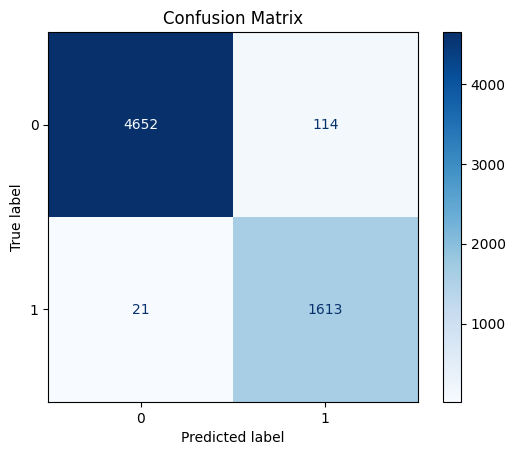

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)


# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("BTPCNN_Save.h5")
model.save_weights("BTPCNN_Saveweight..weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model=load_model('/content/BTPCNN_Save.h5')

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


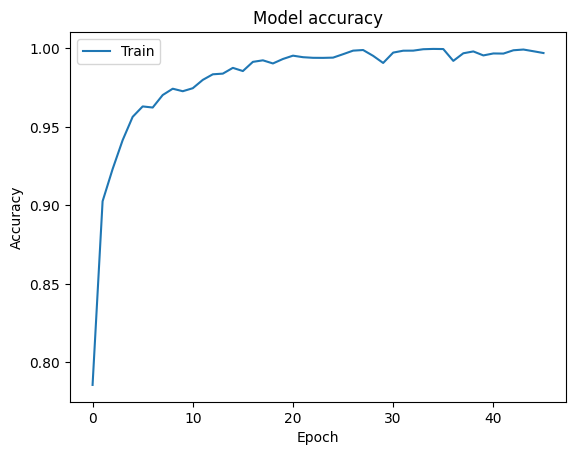

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

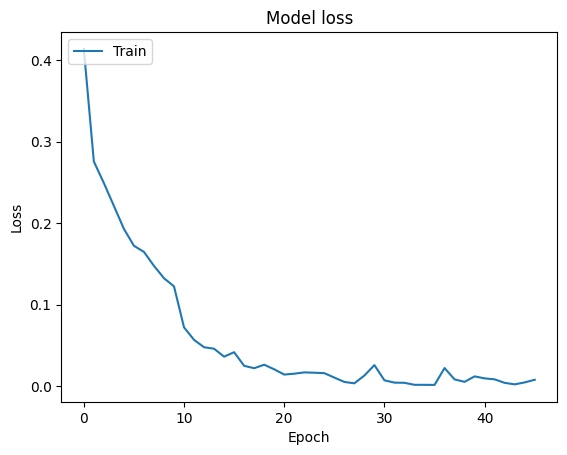

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

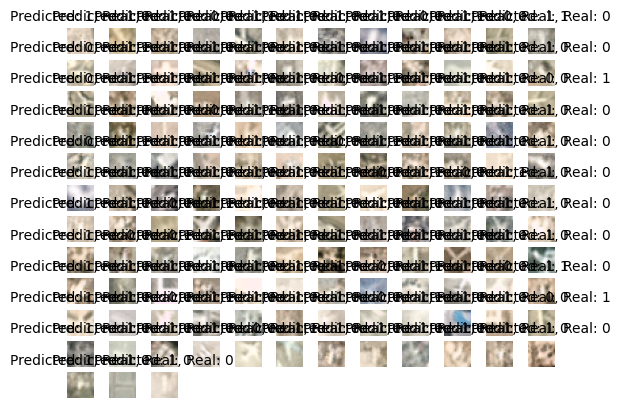

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_real      - ground truth labels
    # y_predicted - predicted label

    count = 0
    figure = plt.figure()

    # Get incorrect label indices
    incorrect_label_indices = (y_real != y_predicted)

    # Filter data for incorrect labels
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    # Calculate grid size (convert to int)
    maximum_square = int(np.ceil(np.sqrt(x_data.shape[0])))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title(f"Predicted: {int(y_predicted[i])}, Real: {int(y_real[i])}", fontsize=10)

    plt.show()

# Example usage
visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())


In [ ]:
#Predictions
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/BTPCNN_Save.h5')

# Function to preprocess and predict the class of a new image
def predict_image_class(image_path, model, target_size=(20, 20)):
    # Step 1: Load the image
    img = load_img(image_path, target_size=target_size)  # Resize to target size
    img_array = img_to_array(img)  # Convert to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image to [0, 1]

    # Step 2: Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index with the highest score

    if predicted_class == 0:
        result = "Aircraft is not present"
    else:
        result = "Aircraft is present"

    return result, predicted_class, predictions

# Example usage:
image_path = '/content/planesnets/planesnet/0__20140723_181317_0905__-122.073653222_37.7090043618.png'
result,predicted_class,predictions = predict_image_class(image_path, model)

# Display the prediction
print(f"Predicted Class: {predicted_class}")
print(f"result: {result}")
print(f"Predictions: {predictions}")


1/1 [==============================] - 0s 81ms/step
Predicted Class: 0
result: Aircraft is not present
Predictions: [[1.160328e-07]]
